# DSS Example: Avoided Fire

This notebook is an example implementation of a notebook-based decision-support system (DSS) for evaluating the net system-level carbon emissions impact of an _avoided fire_ type project. 

## DSS implementation notes

At its core this DSS prototype uses ws3 and libcbm_py to do most of the heavy lifting in terms of simulating forest growth, simulating harvesting disturbances, and simulating forest ecosystem carbon stocks and fluxes. ws3 includes built-in functions that automate most of process of compiling CBM input data, importing this input data into CBM, running CBM, and extracting CBM output data in tablular format.

This DSS assumes we are using the standard "alternative scenario net of baseline scenario" approach to defining net carbon emissions, so we include functions that automate the process of pushing a pair of (baseline, alternative) scenarios through the simulation pipeline, collecting the output from each scenario, calculating the difference across scenarios (alternative minus baseline) and displaying this contrast as a function of time.

Note that most of the complex code that defines the behaviour of the DSS and underlying simulation engines is implemented in a companion `util` Python module. The functions we need from the `util` module are imported at the top of this notebook. 

It is also possible to further "hide" the code parts of a Jupyter notebook-based DSS dashboard application by linking _all_ required parameters and controls to interactive widgets, and then running the notebook throught the Voilà dashboard interface (not tested here, but Voilà is part of the standard ecosystem of Jupyter software should not be a problem). For anyone more familiar with the R programming environment, Voilà is to JupyterLab as Shiny is to RStudio (if this analogy is lost on you, then it was not meant for you). 

## Description of case

The study area for this case is a small subset of timber supply area (TSA) 22 in British Columbia. There has been little or no harvesting in this area to date, but in this hypothetical case we are supposing that there is a substantial risk of wildfire burning part of this forest in the future (e.g., as a result of climate-change-induced drought, decades of fire suppression policy, etc). We are assuming that it is possible to reduce the risk of future fire by deploying effort toward various types of fire risk reducing treatments (e.g., collecting fuel, controlled burns, thinning, creating fire breaks to limit fire spread, etc). We do not have any good data in this hypothetical case on either the cost or the effectiveness of these hypothetical treatments, but we nonetheless want to try put some bounds on the solution space to get a better idea of what is possible in terms of hypothetical emissions reductions. 

To achieve this, we simulate a "maximum annual area burned" landscape level fire scenario based on the fire return internal of each stand type in the model. We then simulate ten reduced burning scenarios, in 10% increments (i.e., all the way down to "no fire"). This is not a "process-based" simulation, so we offer no mechanistic explanation for how the implicit "fire mitigation" treatments achieve these incremental reductions in burned area, or how much effort (cost) is required to implement the treatments at each increment (typically in the real world, one might expect a "diminishing marginal benefit" pattern for this sort of system, assuming that the next highest marginal return stands available are treated at each increment). 

The idea here is to skip over all of the details of the mitigation treatments (because there is no hope of modelling that at this stage, given the data we have available) and calculate the _net emission impact_ of achieving a given incremental level of reduced annual burned area. Given a maximum unit emission reduction price one was willing to pay, it is possible to use the output from this DSS to estimate the maximum price one should be willing to pay to achive a given area-burned reduction effect. Obviously there are limitations to how far we can go with this analysis (given limited available input data), but running through this analysis can still perhaps help set some bounds on the maximum "credible" fire risk reduction we can hope to achieve for this forest, and use that as the starting point for developing and testing actual treatment plans.

Note that most of the complex code that defines the behaviour of the DSS and underlying simulation engines is implemented in a companion `util` Python module. The functions we need from the `util` module are imported at the top of this notebook. 

## Deterministic versus Stochastic fire simulation

Note that DSS includes two versions of the fire simulation. The first and simplest version is a deterministic algorithm that burns the oldest stands first at every time step (with burning simulation stopping when a period area-burned target is achieved). The second and more complex version is a stochastic heuristic that selects random-aged stands to burn at each time step until the area-burned target is reached. We display results from both versions of the model in the graph at the bottom of the notebook. Interestingly both version of the model produce very similar results. Considering that the simpler deterministic version of the model runs several orders of magnitude faster than the stochastic version, we recommend using the simpler version in this case.

The purpose of this demo is not specifically to prove that deterministic models are better than stochastic models (they are not... that would be a silly conclusion to draw from a sample size of one). Rather, we wanted to illustrate the flexibility of the modelling framework and the relative ease of testing and comparing multiple simulation approaches before committing to one approach for a given case or situation.

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import ws3.forest
import numpy as np
from util import schedule_fire_areacontrol, compile_scenario, plot_scenario, run_cbm_fire, RandomAreaSelector, GreedyAreaSelector, plot_resultsFuelMitigate_deter_stoch, resultsFuelMitigate_deter_stoch

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'
intensity = np.round(np.arange(0, 1.1, 0.1), decimals=1)
n_rep = 30

In [4]:
fm = ws3.forest.ForestModel(model_name='tsa22',
                            model_path='data/woodstock_model_files_tsa22',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

In [5]:
df_deter_stoch  = resultsFuelMitigate_deter_stoch(fm, intensity, n_rep, is_use_pickle=True)

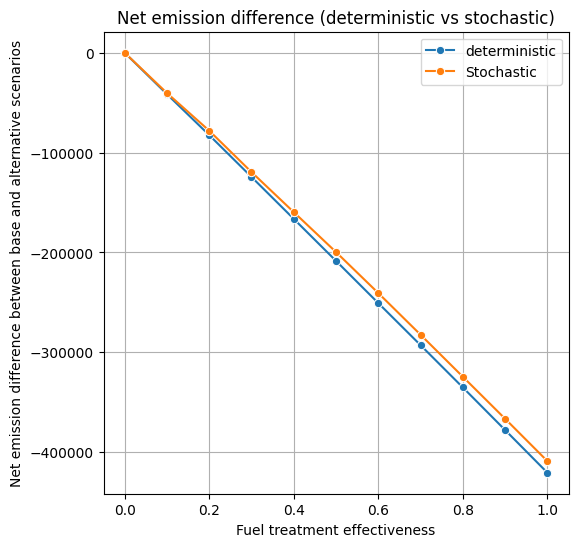

In [6]:
plot_resultsFuelMitigate_deter_stoch(df_deter_stoch)